# Auto Generate Loci Plots

Auto generate plots for each gene. Include ATAC-seq plots per cell state, peak-gene links, zoom in to importance scores of peaks.

In [1]:
library(ggplot2)
library(ggseqlogo)
library(GenomicRanges)
library(patchwork)
library(rtracklayer)
library(BSgenome.Hsapiens.UCSC.hg38)

hg38 = BSgenome.Hsapiens.UCSC.hg38

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

## Loading Inputs

### Day and Cluster Configs

In [3]:
day_config = read.table("../../figures_factory/configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

,day,colour
,<fct>,<chr>
D0,D0,#A61C24
D2,D2,#FF70A6
D4,D4,#D6E82F
D6,D6,#B14AED
D8,D8,#2D3142
D10,D10,#FC7753
D12,D12,#0AABB7
D14,D14,#336699


In [4]:
cluster_config = read.table("../../figures_factory//configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

# print friendly
cluster_config[13, "description"] = "Partially\nreprogrammed"
cluster_config[14, "description"] = "Early\nreprogrammed"

# adding for now, though it should be inside
cluster_config[16,] = c(cluster=16, color="#000000", description="iPSC", new_cluster=15)

cluster_config = cluster_config[!is.na(cluster_config$cluster), ]
rownames(cluster_config) = as.factor(cluster_config$cluster)
cluster_config$new_cluster = as.integer(cluster_config$new_cluster)
cluster_config$cluster = as.integer(cluster_config$cluster)
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#A6D854,Pre-iPSC,14
2,2,#F0A118,Intermediate,12
3,3,#E85F6D,Fibroblast-like,3
4,4,#006658,Neural-like,8
5,5,#B03743,Fibroblast,1
6,6,#CF175A,Fibroblast-like,4
7,7,#78A824,Pre-iPSC,13
8,8,#F4D5CD,Intermediate,11
9,9,#D4B81C,Intermediate,9


### Gene Model

In [5]:
gencode.basic.hg38 = import.gff(gzfile("../../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gene_anno <- data.frame(gencode.basic.hg38)
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]
gene_anno = gene_anno[gene_anno$gene_type=="protein_coding", ]

# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

gene_anno$feature = as.character(gene_anno$type)
gene_anno$exon = gene_anno$exon_id
gene_anno = gene_anno[,c("chromosome", "start", "end", "strand", "gene", "symbol", "transcript", "feature", "exon")]
head(gene_anno)

Warning message in readGFF(filepath, version = version, filter = filter):
“connection is not positioned at the start of the file, rewinding it”


,chromosome,start,end,strand,gene,symbol,transcript,feature,exon
,<fct>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
57,chr1,65419,65433,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003812156.1
58,chr1,65520,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813641.1
59,chr1,65565,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813641.1
60,chr1,65565,65567,+,ENSG00000186092.6,OR4F5,OR4F5-202,start_codon,ENSE00003813641.1
61,chr1,69037,71585,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813949.1
62,chr1,69037,70005,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813949.1


### All Peaks

In [17]:
# PEAK_SETS = "../20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/"
# PEAK_IDXS = seq(20)

# all_peaks = list()
# for (peak_idx in PEAK_IDXS) {
#     all_peaks[[peak_idx]] = read.table(sprintf("../20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx%d.bed",peak_idx))
#     colnames(all_peaks[[peak_idx]]) = c("chr", "start", "end")
#     all_peaks[[peak_idx]] = GRanges(all_peaks[[peak_idx]])
#     all_peaks[[peak_idx]]$peak_set = peak_idx
# }

# all_peaks = do.call("c", all_peaks)

In [268]:
all_peaks = read.table("../20200122_snapATAC/snapATAC_sessions/20201020_n62402/peaks/overlap.no_iPSC.no_clump.range.200.300.bed")[,1:3]
colnames(all_peaks) = c("chr", "start", "end")
all_peaks = GRanges(all_peaks)

In [283]:
all_peaks = sort(all_peaks)
all_peaks

GRanges object with 799303 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       10418-10718      *
       [2]     chr1       42138-42355      *
       [3]     chr1       46208-46408      *
       [4]     chr1       48350-48550      *
       [5]     chr1       48609-48809      *
       ...      ...               ...    ...
  [799299]     chrY 25410711-25410911      *
  [799300]     chrY 26221108-26221308      *
  [799301]     chrY 26315158-26315358      *
  [799302]     chrY 26671020-26671258      *
  [799303]     chrY 56836695-56836895      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

### Importance Score BigWigs + Regions

In [20]:
IMP_BIGWIGS = "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/"
CLUSTERS = c(seq(1,14), 16)

BIGWIG_PATHS = list()

for (i in CLUSTERS) {
    BIGWIG_PATHS[[i]] = paste(IMP_BIGWIGS, "cluster_idx", i, ".bw", sep='')
}

BIGWIG_PATHS

[[1]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx1.bw"

[[2]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx2.bw"

[[3]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx3.bw"

[[4]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx4.bw"

[[5]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx5.bw"

[[6]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx6.bw"

[[7]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx7.bw"

[[8]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx8.bw"

[[9]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx9.bw"

[[10]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx10.bw"

[[11]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx11.bw"

[[12]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx12.bw"

[[13]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx13.bw"

[[14]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx14.bw"

[[15]]
NULL

[[16]]
[1] "/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/interpretation/cluster_idx16.bw"

### Motif Annotations

In [94]:
motif_annotation = read.table("/srv/www/kundaje/surag/scATAC-reprog/clusters/20201020_n62402/beds/hg38.archetype_motifs.v1.0.consolidated.bed.gz")
motif_annotation = motif_annotation[,1:4]
colnames(motif_annotation) = c("chr", "start", "end", "motif")
motif_annotation = GRanges(motif_annotation)

In [97]:
motif_annotation

GRanges object with 1249152 ranges and 1 metadata column:
            seqnames            ranges strand |        motif
               <Rle>         <IRanges>  <Rle> |     <factor>
        [1]     chr1       11224-11238      * | Ebox/CAGATGG
        [2]     chr1       11341-11355      * | Ebox/CAGATGG
        [3]     chr1       42261-42270      * |   CCAAT/CEBP
        [4]     chr1       42280-42288      * |        AP1/1
        [5]     chr1       46306-46320      * |    OCT4+SOX2
        ...      ...               ...    ... .          ...
  [1249148]     chrY 25399304-25399315      * |        ETS/2
  [1249149]     chrY 25399358-25399366      * |        AP1/1
  [1249150]     chrY 26221687-26221696      * |  Ebox/CAGCTG
  [1249151]     chrY 26315267-26315278      * |          YY1
  [1249152]     chrY 26670842-26670856      * | Ebox/CAGATGG
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

## Processing

In [87]:
# one bigwig at a time, any number of peaks
get_matrix_from_bigwig <- function(bigwig_path, peak_set) {
    # ensure peak set has fixed width
    stopifnot(length(unique(width(peak_set)))==1)
    
    as.matrix(import(bigwig_path, 
      which=peak_set, as="NumericList"))
}

In [88]:
# calculate top and bottom percentiles for each state

upper_lims = list()
lower_lims = list()

NUM_SAMP = 100

sampled_peaks = sample(all_peaks, NUM_SAMP)
for (i in CLUSTERS) {
    
    vals = as.vector(get_matrix_from_bigwig(BIGWIG_PATHS[[i]], resize(sampled_peaks, width=500, fix='center')))
    
    upper_lims[[i]] = quantile(vals, 0.999)
    lower_lims[[i]] = quantile(vals, 0.001)
}

## Plotting

In [89]:
# many bigwigs, one peak
get_importance_from_bigwigs <- function(clusters, bigwig_paths, peak) {
    # get DNA sequence
    sequence = hg38[[as.vector(seqnames(peak))]][start(peak):end(peak)]
    
    scores = list()
    
    for (i in clusters) {
        m = matrix(0, length(sequence), 4)
        colnames(m) = c("A", "C", "G", "T")
        m[cbind(seq(length(sequence)), as.vector(matrix(sequence)))] = get_matrix_from_bigwig(bigwig_paths[[i]], peak)
        
        scores[[i]] = t(m)
    }
    
    scores
}

In [58]:
plot_seq <- function(m, ymin, ymax, clip=F, cutrange=NULL) {
    mat = m
    
#     rownames(mat) = c("A", "C", "G", "T")
    
    # cap to upper and lower limits
    if (clip==T) {
        mat[mat>ymax] = ymax
        mat[mat<ymin] = ymin
    }
    
    
    if (length(cutrange) == 0) {
        p = ggseqlogo(mat, method='custom', seq_type='dna') 
    }
    
    else {
        p = ggseqlogo(mat[,cutrange], method='custom', seq_type='dna') 
    }
    
    p = p + theme_void() + coord_cartesian(ylim=c(ymin, ymax))
    
    p
}

In [190]:
plot_imp_across_tasks <- function(peak, clip=T, cutrange=NULL) {
    # extracts importance scores for region from all clusters (if available)
    imp_scores_plots = c()
    
    imp_scores = get_importance_from_bigwigs(CLUSTERS, BIGWIG_PATHS, peak)
        
    for (i in CLUSTERS) {
        if (sum(imp_scores[[i]])!=0) {
            imp_scores_plots[[i]] = plot_seq(imp_scores[[i]],
                                        lower_lims[[i]], 
                                        upper_lims[[i]],
                                        clip=clip, 
                                        cutrange=cutrange)
        }
        else {
            imp_scores_plots[[i]] = plot_spacer()
        }
    }
    
    imp_scores_plots
}

In [60]:
options(repr.plot.width = 5, repr.plot.height = 24)
cluster_config_selected = cluster_config[as.character(CLUSTERS),]
cluster_config_selected$y = factor(paste(cluster_config_selected$new_cluster, cluster_config_selected$description, sep=' - '))
levels(cluster_config_selected$y) = cluster_config_selected$y[rev(order(cluster_config_selected$new_cluster))]

cluster_colourbar <- ggplot(cluster_config_selected, 
                            aes(x=1, 
                            y=y, 
                            fill = y, 
                            label= y)) +
  geom_bar(stat="identity") +
#   ylab("scRNA Cell State") +
  theme_void() +
  scale_fill_manual(values = as.character(cluster_config_selected$colour[rev(order(cluster_config_selected$new_cluster))])) +
  theme(legend.position = 'none',
        axis.text.y = element_text(size=26, margin=margin(t= 10)),
#         axis.title.y = element_text(size=20, angle=90, margin=margin(t=10))
       ) # adjust this to match heights

In [226]:
plot_motif_track <- function(peak) {
    motifs_in_frame = motif_annotation[queryHits(findOverlaps(motif_annotation, peak))]
    p = ggplot() + annotate("point", x=1, y=1) + annotate("point", x=end(peak)-start(peak), y=1)
    
    if (length(motifs_in_frame)==0) {
        p = plot_spacer()
    }
    
    else {
        
        for (i in seq(length(motifs_in_frame))) {
            cur_motif = motifs_in_frame[i]

            p = p + annotate("rect", 
                             xmin=max(0,start(cur_motif)-start(peak)+2),
                             xmax=min(end(cur_motif)-start(peak)+2, end(cur_motif)),
                             ymin=0, ymax=1, color="black", fill="white") +
                    annotate("text",
                             x=((start(cur_motif)+end(cur_motif))/2-start(peak)+2),
                             y = 0.5, label=as.character(cur_motif$motif), color="black", size=10)
        }
    }
    
    p + theme_void()
}

In [256]:
plot_peak <- function(peak, clip=T, cutrange=NULL) {
    width_ratios = c(1,((width(peak)/5)-1))
    
    imp_plot = plot_imp_across_tasks(peak, clip, cutrange)
    
    motif_track = plot_motif_track(peak)
    p = wrap_plots(cluster_colourbar,
           wrap_plots(imp_plot[CLUSTERS[order(cluster_config[as.character(CLUSTERS), "new_cluster"])]],
                      ncol=1),
           widths = width_ratios)
    
    p = wrap_plots(p,
                   wrap_plots(plot_spacer(), motif_track, widths=width_ratios),
                   heights=c(length(imp_plot), 0.5))
    p + plot_annotation(title = as.character(peak),
                                   theme= theme(plot.title = element_text(size = 36)))
}

In [290]:
peak = resize(GRanges("chr9:112582968-112583095"), width=200, fix="center")
# peak = GRanges("chr19:44906601-44906616")

In [291]:
as.character(peak) 

[1] "chr9:112582932-112583131"

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



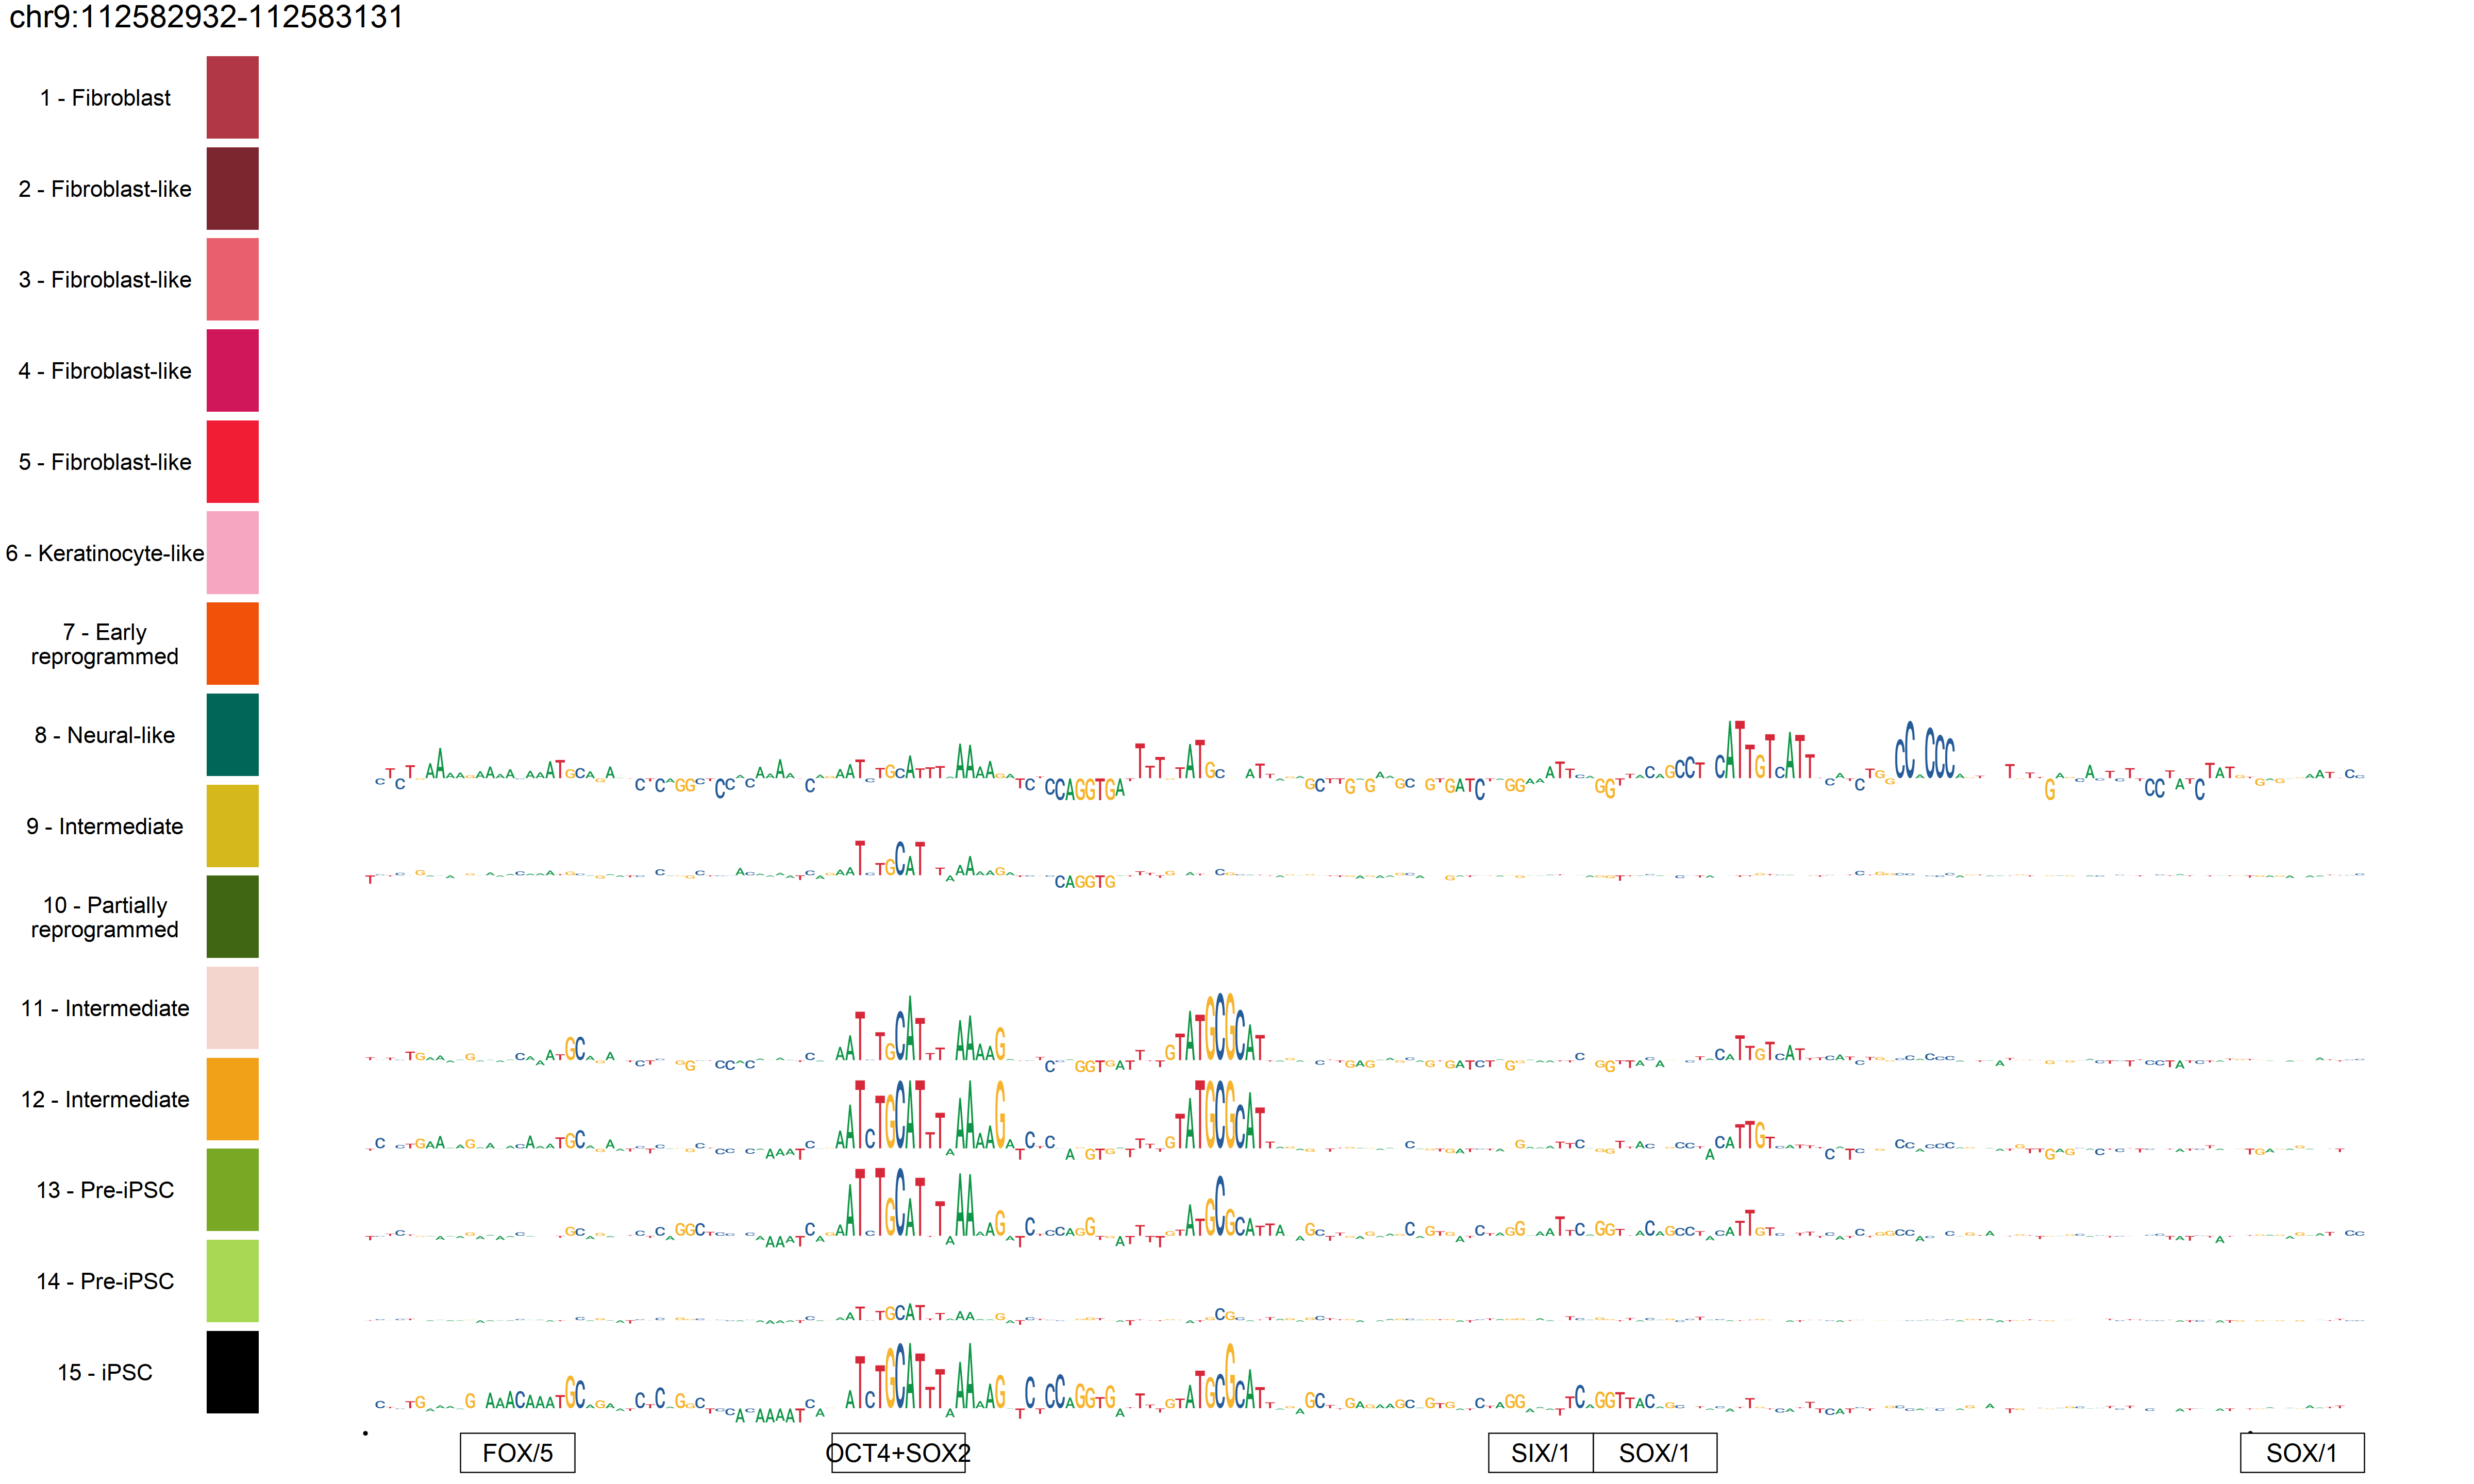

In [292]:
H = 24
options(repr.plot.width = width(peak)/5, repr.plot.height = H)

plot_peak(peak) 

## Plotting for many gene regions

In [286]:
# genes_of_interest = c("MYC", "ZFP42", "NANOG")
 genes_of_interest = c("POU5F1", "SOX2", "MYCN")

In [287]:
gene_anno[gene_anno$symbol=="NANOG" & gene_anno$feature=="start_codon",][1,]

,chromosome,start,end,strand,gene,symbol,transcript,feature,exon
,<fct>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
1056294,chr12,7789615,7789617,+,ENSG00000111704.11,NANOG,NANOG-201,start_codon,ENSE00000867802.7


In [288]:
peaks_around_gene[i]

GRanges object with 1 range and 0 metadata columns:
      seqnames          ranges strand
         <Rle>       <IRanges>  <Rle>
  [1]    chr12 7886071-7886270      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [289]:
WIDTH = 100*1000 # on each side

for (g in genes_of_interest) {
    # take first of many possibel start codons 
    start_codon = gene_anno[gene_anno$symbol==g & gene_anno$feature=="start_codon",][1,]
    start_codon = GRanges(paste(paste(as.character(start_codon$chromosome), 
                                      start_codon$start, sep=':'),
                                start_codon$end, sep='-'))
    peaks_around_gene = all_peaks[queryHits(findOverlaps(all_peaks, start_codon+WIDTH))]
    
    peaks_around_gene = resize(peaks_around_gene, width=200, fix="center")
    print(length(peaks_around_gene))
    gene_plots = list()
    
#     for (i in seq(length(peaks_around_gene))) {
    for (i in seq(length(peaks_around_gene))) {
        gene_plots[[i]] = plot_peak(peaks_around_gene[i])
    }
    
    pdf(sprintf("./plots/%s.pdf", g), width = 40, height = 24, onefile = TRUE)
    for (i in seq(length(gene_plots))) {
      print(gene_plots[[i]])
    }
    dev.off()
}

[1] 114


Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which wi

[1] 46


Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which wi

[1] 26


Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which wi

png 
  2